In [2]:
import numpy as np
import deeptrack as dt
import deeplay as dl
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import random
import cv2

In [73]:

image = dt.LoadImage("cope_4.png")

plt.figure(figsize=(15, 10))
image = np.array(image.resolve()) #Note to self, resolve() makes it into a list
print(np.shape(image))
#plt.imshow(image)

(5202, 3464, 3)


<Figure size 1500x1000 with 0 Axes>

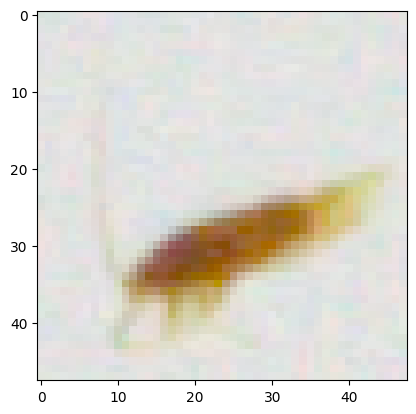

In [81]:
crop_size =48
y_index = 1600
x_index = 1200
x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
training_image = np.array(   image[x0:x0+crop_size, y0: y0 + crop_size])
plt.imshow(training_image)

# Prepare cropped sample

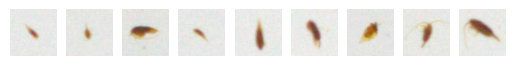

In [4]:

crops = [45,45,45,45,45,45,45,45,45,45,45]
ys    = [1875,    1487,  955,1740,2693,2955,1430,1970,2537 ] # ,1945,1480,,2955,2345,1864,1525,3087,
xs    = [1785,   1550,   2050,1825,2010,2040,2395,850,1484] #  ,1230,1595,,2040 1070, 920, 1517,1773,
training_images = []
number_of_crops = len(ys)
#x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
#training_image = np.array(   image[x0:x0+crop_size, y0: y0 + crop_size])


for i in range(number_of_crops):
    #go through the positions for the crops
    y_index   = ys[i]
    x_index   = xs[i]
    crop_size = 50
    x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
    training_image = np.array(   image[x0:x0+crop_size, y0: y0 + crop_size])
    training_images.append(training_image)
    plt.subplot(1,number_of_crops,i+1)
    plt.axis("off")
    plt.imshow(training_image)


random_crop = dt.Value(lambda: random.choice(training_images))
#np.expand_dims(training_images, axis=-1)

    


In [5]:
downsample = 2
training_pipeline = (
    
    dt.Value(random_crop)
    >> dt.AveragePooling(ksize=(downsample, downsample, 1))
    #>> dt.Affine(rotate=lambda: np.random.rand()*np.pi*2)
    >> dt.Multiply(lambda: np.random.uniform(0.95, 1.05))
    >> dt.Add(lambda: np.random.uniform(-0.07, 0.07))
    >> dt.MoveAxis(-1, 0)

    >> dt.pytorch.ToTensor(dtype=torch.float32)

)
training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, replace=False)

In [6]:
dataloader = dl.DataLoader(training_dataset,batch_size=8,shuffle=True,num_workers=6)

# Train LodeSTAR with cropped sample

In [7]:
epochs = 35
lodestar = dl.LodeSTAR(n_transforms=4,optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=epochs)
trainer.fit(lodestar,dataloader)

/home/alex/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-04-05 16:54:42.823804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 16:54:42.935666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alex/.local/lib/python3.10/site-packages/cv2/../../lib64:
2024-04-05 16:54:42.935680: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
202

Epoch 34: 100%|██████████| 50/50 [00:02<00:00, 17.19it/s, v_num=9, train_between_image_disagreement_step=0.0275, train_within_image_disagreement_step=0.0207, train_between_image_disagreement_epoch=0.037, train_within_image_disagreement_epoch=0.0209]  


# Evaluate Performance

In [8]:
'''
#Downsample test image so it can be fed without crashing the pc
#Try cope_2.png

image = dt.LoadImage("cope_1.png")
plt.figure(figsize=(15, 10))
image = np.array(image.resolve()) #Note to self, resolve() makes it into a list


import cv2
rescale_factor = 0.8
new_width  = int(image.shape[1]*rescale_factor)
new_height = int(image.shape[0]*rescale_factor)
test_image = cv2.resize(image, (new_width,new_height),interpolation=cv2.INTER_AREA) 
print(np.shape(test_image))
torch_image = torch.from_numpy(test_image[0:3000,:,:]).permute(2,0,1).unsqueeze(0).float()


#Feed to LodeSTAR
prediction = lodestar(torch_image)[0].detach().numpy()
x, y, rho  = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(17,11))
plt.subplot(1,3,1)
plt.imshow(test_image[0:3000,:,:])
plt.title("Input image")

plt.subplot(1,3,2)
plt.imshow(rho,cmap="gray")
plt.title("Predicted image")
'''

'\n#Downsample test image so it can be fed without crashing the pc\n#Try cope_2.png\n\nimage = dt.LoadImage("cope_1.png")\nplt.figure(figsize=(15, 10))\nimage = np.array(image.resolve()) #Note to self, resolve() makes it into a list\n\n\nimport cv2\nrescale_factor = 0.8\nnew_width  = int(image.shape[1]*rescale_factor)\nnew_height = int(image.shape[0]*rescale_factor)\ntest_image = cv2.resize(image, (new_width,new_height),interpolation=cv2.INTER_AREA) \nprint(np.shape(test_image))\ntorch_image = torch.from_numpy(test_image[0:3000,:,:]).permute(2,0,1).unsqueeze(0).float()\n\n\n#Feed to LodeSTAR\nprediction = lodestar(torch_image)[0].detach().numpy()\nx, y, rho  = prediction[0], prediction[1], prediction[-1]\n\nplt.figure(figsize=(17,11))\nplt.subplot(1,3,1)\nplt.imshow(test_image[0:3000,:,:])\nplt.title("Input image")\n\nplt.subplot(1,3,2)\nplt.imshow(rho,cmap="gray")\nplt.title("Predicted image")\n'

In [9]:

alpha = 0.6 #Dissimilarity parameter, higher = more dissimilar plankton
beta  = 1-alpha   #Clustering    parameter, higher = clusters need to be more well defined to be included
cutoff = 0.8 #0.75 for cope_1
mode= "constant"

detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                 mode="constant", cutoff=cutoff)[0]
detection_number = len(detections[:,1])                          
print(f"Detections: {detection_number}")
print(f"Record = 533")

plt.figure(figsize=(15, 10))
plt.imshow(test_image, cmap="gray")
plt.scatter(detections[:, 1], detections[:, 0],marker="o",facecolors="none",edgecolors='r',linewidths=0.3)
plt.axis("off")
plt.show()


NameError: name 'torch_image' is not defined

In [13]:
alpha  = 0.6       #Dissimilarity parameter, higher = more dissimilar plankton
beta   = 1-alpha   #Clustering    parameter, higher = clusters need to be more well defined to be included
cutoff = 0.9       #0.75 for cope_1
mode   = "constant"

rescale_factor = 0.7

do_inference    = True
test_directory  = "test_images/"
img_directory   = "results_LodeSTAR/images"
csv_directory   = "results_LodeSTAR/position_data/"

if do_inference:
    for image_name in os.listdir(test_directory):
        if image_name.endswith(('.png')):

            #Load image
            image_path = os.path.join(test_directory,image_name)
            image = dt.LoadImage(image_path)
            image = np.array(image.resolve())

            #Rescale image
            new_width  = int(image.shape[1]*rescale_factor)
            new_height = int(image.shape[0]*rescale_factor)
            test_image = cv2.resize(image, (new_width,new_height),interpolation=cv2.INTER_AREA) 

            #Convert to torch and feed to LodeSTAR
            torch_image = torch.from_numpy(test_image).permute(2,0,1).unsqueeze(0).float()
            detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                    mode="constant", cutoff=cutoff)[0]

            detection_number = len(detections[:,1])                          
            print(f"Detections = {detection_number}")

            #generate names to save data
            save_img_name   = f"{os.path.splitext(image_name)[0]}_{detection_number}"
            save_csv_name   = f"{os.path.splitext(image_name)[0]}.csv"

            save_img_path   = os.path.join(img_directory,save_img_name)
            save_csv_path   = os.path.join(csv_directory,save_csv_name)


            plt.figure(figsize=(15, 10))
            plt.imshow(test_image, cmap="gray")
            plt.scatter(detections[:, 1], detections[:, 0],marker="o",facecolors="none",edgecolors='r',linewidths=0.3)
            plt.axis("off")
            plt.savefig(save_img_path)
            plt.close()

            np.savetxt(save_csv_path,detections,delimiter=',',fmt='%d')


Detections = 500
Detections = 192
Detections = 330
Detections = 605
Detections = 296
Detections = 99
Detections = 248
Detections = 193
Detections = 236
Detections = 254
Detections = 269
Detections = 190
Detections = 325
Detections = 268
Detections = 121
Detections = 140
Detections = 304
Detections = 144
Detections = 596
Detections = 191
Detections = 351
Detections = 94
Detections = 677
Detections = 219
Detections = 355
Detections = 75
Detections = 305
Detections = 564
Detections = 345
Detections = 70
Detections = 252
Detections = 280
Detections = 482
Detections = 334
Detections = 269
Detections = 113
Detections = 373
Detections = 407
Detections = 104
Detections = 401
Detections = 562
Detections = 779
Detections = 135
Detections = 216
Detections = 163
Detections = 758
Detections = 102
Detections = 254
Detections = 355
Detections = 362
Detections = 146
Detections = 245
Detections = 297
Detections = 277
Detections = 235
Detections = 423
Detections = 374
